In [32]:
import cv2, os, numpy as np

In [33]:
target_directory = 'FullDataset' 
output_directory = 'TrainingImages'

In [34]:
os.makedirs(output_directory, exist_ok=True)

In [35]:
def transformar_para_quadrada(imagem, tamanho_final):
    # Obter as dimensões da imagem
    altura, largura = imagem.shape[:2]

    # Calcular o tamanho do quadrado
    lado_quadrado = max(altura, largura)

    # Criar uma nova imagem quadrada com fundo preto
    imagem_quadrada = np.zeros((lado_quadrado, lado_quadrado, 3), dtype=np.uint8)

    # Colocar a imagem original no centro da nova imagem quadrada
    y_offset = (lado_quadrado - altura) // 2
    x_offset = (lado_quadrado - largura) // 2
    
    # Converter a imagem em escala de cinza para 3 canais
    imagem_colorida = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)
    imagem_quadrada[y_offset:y_offset + altura, x_offset:x_offset + largura] = imagem_colorida

    # Redimensionar para o tamanho final desejado
    imagem_quadrada = cv2.resize(imagem_quadrada, (tamanho_final, tamanho_final), interpolation=cv2.INTER_CUBIC)

    return imagem_quadrada

for letter_folder in os.listdir(target_directory):
    letter_path = os.path.join(target_directory, letter_folder)
    
    if os.path.isdir(letter_path):
        for image_file in os.listdir(letter_path):
            image_path = os.path.join(letter_path, image_file)
            
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    imagem_final = transformar_para_quadrada(gray_image, 512)
                    
                    largura_borda = 10  # ajuste conforme necessário
                    imagem_com_borda = cv2.copyMakeBorder(
                        imagem_final,
                        largura_borda,
                        largura_borda,
                        largura_borda,
                        largura_borda,
                        cv2.BORDER_CONSTANT,
                        value=[0, 0, 0]  # cor da borda (preto, por exemplo)
                    )

                    # Garantir que a imagem final não ultrapasse 512x512
                    imagem_com_borda = cv2.resize(imagem_com_borda, (512, 512), interpolation=cv2.INTER_CUBIC)
                                        
                    output_path = os.path.join(output_directory, letter_folder)
                    os.makedirs(output_path, exist_ok=True)
                    
                    gray_image_path = os.path.join(output_path, image_file)
                    cv2.imwrite(gray_image_path, imagem_com_borda)
       
            except Exception as e:
                print(f"Erro ao abrir a imagem {image_path} : {e}")


In [4]:
import cv2
import mediapipe as mp
import pandas as pd
import os

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Function to extract hand landmarks
def extract_hand_landmarks(image_path):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Convert grayscale image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Process the image to find hand landmarks
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        return [(lm.x, lm.y) for lm in landmarks.landmark]
    return None

# Directory containing ASL images organized by letter
image_directory = 'TrainingImages'
# List to hold data
data = []

# Loop through each subfolder (each letter of the alphabet)
for label in os.listdir(image_directory):
    label_path = os.path.join(image_directory, label)
    
    # Check if it's a directory (skip files in the main folder, if any)
    if os.path.isdir(label_path):
        # Loop through images in each subfolder
        for filename in os.listdir(label_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(label_path, filename)
                landmarks = extract_hand_landmarks(image_path)
                
                if landmarks:
                    # Append the label and landmarks to the data list
                    data.append([label] + [coord for landmark in landmarks for coord in landmark])
    

# Create a DataFrame
columns = ['Label'] + [f'Landmark_{i}_{axis}' for i in range(21) for axis in ['x', 'y']]
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv('asl_landmarks.csv', index=False)


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Carregar dados do CSV gerado
df = pd.read_csv('asl_landmarks.csv')

# Separar features (Landmarks) e target (Label)
X = df.drop('Label', axis=1)  # Todos os pontos de landmarks são as features
y = df['Label']               # A coluna Label é o target

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciar e treinar o modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"Relatório de Classificação:\n{report}")


Acurácia: 0.9651815799326096
Relatório de Classificação:
              precision    recall  f1-score   support

           A       0.98      0.98      0.98       673
           B       0.98      1.00      0.99       340
           C       0.99      0.95      0.97       124
           D       0.98      0.93      0.95       208
           E       0.93      0.96      0.95       437
           F       0.98      0.99      0.98       336
           G       0.97      1.00      0.98       529
           H       0.98      0.97      0.98       356
           I       0.99      0.97      0.98       248
           J       0.99      0.99      0.99       328
           K       0.99      0.97      0.98       478
           L       0.96      0.97      0.96       267
           M       0.94      0.91      0.92       148
           N       0.94      0.94      0.94       154
           O       0.95      0.91      0.93       115
           P       0.98      0.96      0.97       218
           Q       0.97 

Dimensões da imagem: (512, 512, 3)


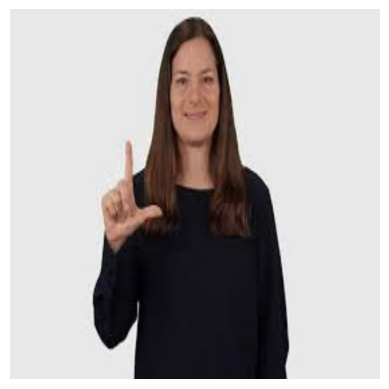

Resultados do processamento: <class 'mediapipe.python.solution_base.SolutionOutputs'>
Número de mãos detectadas: 1
Mão detectada.


c:\Users\disrct\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


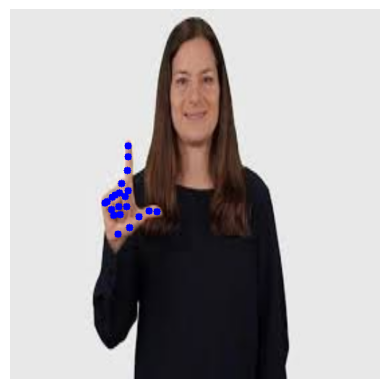

Landmarks extraídos: [0.2915647327899933, 0.6078254580497742, 0.32284432649612427, 0.5904109477996826, 0.3493378162384033, 0.5614117383956909, 0.37504440546035767, 0.5462242364883423, 0.3978930711746216, 0.5483156442642212, 0.319719523191452, 0.4920397698879242, 0.31826940178871155, 0.43661805987358093, 0.3195304274559021, 0.39985916018486023, 0.31938615441322327, 0.37080705165863037, 0.29662466049194336, 0.49752578139305115, 0.30184924602508545, 0.4725581705570221, 0.3106299042701721, 0.5059658885002136, 0.31482982635498047, 0.5343097448348999, 0.27571117877960205, 0.5089501142501831, 0.2832576334476471, 0.5022774338722229, 0.2935842275619507, 0.53400057554245, 0.29794713854789734, 0.5558492541313171, 0.2567727863788605, 0.5247764587402344, 0.2635262608528137, 0.5199633836746216, 0.27446895837783813, 0.5421194434165955, 0.28000253438949585, 0.5572439432144165]
A letra prevista é: L


c:\Users\disrct\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [52]:
import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt

# Inicialize o MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Função para extrair landmarks de uma nova imagem e fazer previsão
def predict_letter(image_path, model):
    # Carregar a imagem em RGB
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Erro: A imagem não foi carregada em {image_path}.")
        return None
    
    # Opcional: Redimensionar a imagem se necessário
    image = cv2.resize(image, (512, 512))
    
    # Debug: Verificar dimensões da imagem
    print(f"Dimensões da imagem: {image.shape}")

    # Exibir a imagem original
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # Processar a imagem para encontrar os landmarks da mão
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Debug: Verificar a saída do processamento
    print("Resultados do processamento:", results)
    print("Número de mãos detectadas:", len(results.multi_hand_landmarks) if results.multi_hand_landmarks else 0)

    if results.multi_hand_landmarks:
        print("Mão detectada.")
        # Extrair os landmarks da mão
        landmarks = results.multi_hand_landmarks[0]

        # Desenhar landmarks na imagem
        for hand_landmarks in results.multi_hand_landmarks:
            for landmark in hand_landmarks.landmark:
                # Ponto (x, y)
                h, w, _ = image.shape
                cx, cy = int(landmark.x * w), int(landmark.y * h)
                cv2.circle(image, (cx, cy), 5, (255, 0, 0), -1)  # Ponto azul

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

        # Formatar as coordenadas em uma lista única
        landmark_data = [coord for lm in landmarks.landmark for coord in (lm.x, lm.y)]
        
        # Debug: Verificar os landmarks extraídos
        print(f"Landmarks extraídos: {landmark_data}")

        # Transformar em um DataFrame para compatibilidade com o modelo
        input_df = pd.DataFrame([landmark_data])
        
        # Fazer previsão com o modelo
        prediction = model.predict(input_df)
        
        return prediction[0]  # Retorna a letra prevista
    else:
        print("Nenhuma mão detectada na imagem.")
        return "Nenhuma mão detectada na imagem."

# Exemplo de uso
image_path = 'a.png'
predicted_letter = predict_letter(image_path, rf_model)
print(f"A letra prevista é: {predicted_letter}")
